# Exercise 16 - 3D CNN for Building Roof Classification

# Setup TensorFlow

In [1]:
# Change X to the GPU number you want to use,
# otherwise you will get a Python error
# e.g. USE_GPU = 4
USE_GPU = 4

In [2]:
# Import TensorFlow 
import tensorflow as tf

# Print the installed TensorFlow version
print(f'TensorFlow version: {tf.__version__}\n')

# Get all GPU devices on this server
gpu_devices = tf.config.list_physical_devices('GPU')

# Print the name and the type of all GPU devices
print('Available GPU Devices:')
for gpu in gpu_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set only the GPU specified as USE_GPU to be visible
tf.config.set_visible_devices(gpu_devices[USE_GPU], 'GPU')

# Get all visible GPU  devices on this server
visible_devices = tf.config.get_visible_devices('GPU')

# Print the name and the type of all visible GPU devices
print('\nVisible GPU Devices:')
for gpu in visible_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set the visible device(s) to not allocate all available memory at once,
# but rather let the memory grow whenever needed
for gpu in visible_devices:
    tf.config.experimental.set_memory_growth(gpu, True)
    
# Import Keras
from tensorflow import keras

# Print the installed Keras version
print(f'\nKeras version: {keras.__version__}\n')

TensorFlow version: 2.3.0

Available GPU Devices:
  /physical_device:GPU:0 GPU
  /physical_device:GPU:1 GPU
  /physical_device:GPU:2 GPU
  /physical_device:GPU:3 GPU
  /physical_device:GPU:4 GPU
  /physical_device:GPU:5 GPU
  /physical_device:GPU:6 GPU
  /physical_device:GPU:7 GPU

Visible GPU Devices:
  /physical_device:GPU:4 GPU

Keras version: 2.4.0



## Classification of aerial LiDAR data with 3D CNN

So far, to process LiDAR data with 2D CNN we have rasterized the point clouds by projecting them onto the horihontal plane. Because LIDAR data is aquired from nadir postion, such a projection does not lead to a significalt information loss. However, there are cases, when it is desirable that the granularity of the data is preserved as much as possible. A step towards this goal can be a 3D approach to CNN. 

### LEARNING OBJECTIVES
* practice with volumetric CNN
* understand the input, kernel dimensions
* understand the computational requirements of 3D CNN

In order for you to practice with this type of networks, a subset from the dataset RoofNet3D has been extracted and pre-processed.
You can find the dataset at the usual location, and it is organized according to the roof classes and already split in training, validation and testing sets. 

The training sets includes over 3000 examples, where tree types of roofs, Pyramid, Saddleback and Two sided hip roof are equally represented.
Each data point is stored as a numpy array of shape $(32,32,32)$ and represent the voxel occupancy (voxel where LiDAR points were falling have value 1, the rest have value 0)

In order to feed the training data for training your model you will use the provided custom generator function _generator.py_.
Please make sure that the path to the data in this file is set correct.

In [3]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

### Load and visualize the data

In [4]:
import generator
BATCH_SIZE = generator.BATCH_SIZE

In [5]:
class_names = ['Two-sided hip roof', 'Pyramid roof','Saddleback roof']

In [6]:
from pathlib import Path
ROOT = str(Path.home()) + r'/coursematerial/GIS/lidar_dataset_classification_3D_res_32'

data_gen_training = generator.training_gen(dir=ROOT)

In [7]:
vox_list, gt_roof_list = next(data_gen_training)

Repeat the following 3 cells to get a different random roof in voxel representation and its label.

In [8]:
indx = np.random.randint(BATCH_SIZE)
vox_roof=vox_list[indx,:]
vox_roof_sq = np.squeeze(vox_roof)
vox_roof_b = vox_roof_sq !=0

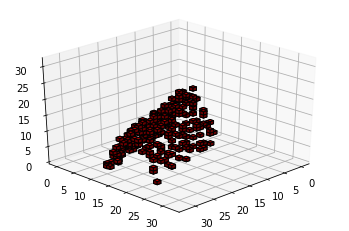

In [9]:
colors = np.empty(vox_roof_b.shape, dtype=object)
colors[vox_roof_b] = 'red'
fig = plt.figure()
ax = fig.gca(projection='3d')

# you can change the rotation of the view with the second argument
ax.view_init(30, 45)

ax.voxels(vox_roof_b, facecolors=colors, edgecolor='k')
plt.show()

What you see are voxels generated from the points of the roof only. Facade and ground points are filtered.

In [10]:
roof_label = class_names[np.argmax(gt_roof_list[indx])]
print(roof_label)

Saddleback roof


In [11]:
INPUT_DIM = (generator.VOXEL_HEIGHT,generator.VOXEL_WIDTH, generator.VOXEL_DEPTH,1)
OUTPUT_DIM = (generator.NUM_CLASSES)

### Building a 3D CNN model

To build a 3D CNN model for classification is very similar to building a 2D CNN model, the difference is the additional dimension of the input and of the kernels.
You will build the classification model using [Conv3D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv3D) and [MaxPool3D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool3D).

1) First, use the `Input` function to define your input tensor. Make sure you provide the right input shape. Assign the input tensor to a variable _inputs_.

2) Use a [Conv3D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv3D) layer. Provide values for the number of filters and kernes size. (you can try 16, (3,3,3)). Choose an appropriate activation. Apply this layer to the _inputs_. Assign the output tensor to a variable $x$.

3) Use a [MaxPool3D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool3D) layer to downsample your feature maps by a factor of 2.  Apply this layer to the previous output tensor. Assign the output tensor to a variable $x$.

4) Use a [Conv3D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv3D) layer. provide values for the number of filters and kernes size. (you can try to double the number of filters and keep the previous kernel size. Choose an appropriate activation. Apply this layer to the previous output tensor. Assign the output tensor to a variable $x$.

5) Use a [MaxPool3D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool3D) layer to downsample your feature maps by a factor of 2. Apply this layer to the previous output tensor. Assign the output tensor to a variable $x$.

6) Use a [Conv3D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv3D) layer. provide values for the number of filters and kernes size. (you can try to double the number of filters and keep the previous kernel size.  Choose an appropriate activation. Apply this layer to the previous output tensor. Assign the output tensor to a variable $x$.

7) Use a [MaxPool3D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool3D) layer to downsample your feature maps by a factor of 2. Apply this layer to the previous output tensor. Assign the output tensor to a variable $x$.

8) Use the [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) function to project to previous output tensor in a vector. Assign the output tensor to a variable $x$.

9) Use a [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer. Choose an appropriate activation. Provide the number of neurons for this layer (you can try 256).  Assign the output tensor to a variable $x$.

10) Use a [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer. Choose an appropriate dropuout rate.  Assign the output tensor to a variable $x$.

11) Use a [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer. Provide the number of neurons for this layer (the output dim!!).  Choose an appropriate activation. (Which activation function is used for the last layer to get class probabilities?) Assign the output tensor to a variable $outputs$.

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPool3D, Flatten, Dense, Dropout

In [19]:
#1
inputs = Input(INPUT_DIM)

#2 Conv3D
Conv3D1 = Conv3D(16, (3,3,3), padding="same")(inputs)
x = tf.keras.layers.ReLU()(Conv3D1)

#3 MaxPool3D
x = MaxPool3D(pool_size=(2, 2, 2))(x)

#4 Conv3D
Conv3D2 = Conv3D(32, (3,3,3), padding="same")(x)
x = tf.keras.layers.ReLU()(Conv3D2)

#5 MaxPool3D
x = MaxPool3D(pool_size=(2, 2, 2))(x)

#6 Conv3D
Conv3D3 = Conv3D(64, (3,3,3), padding="same")(x)
x = tf.keras.layers.ReLU()(Conv3D3)

#7 MaxPool3D
x = MaxPool3D(pool_size=(2, 2, 2))(x)

#8 Flatten
x = Flatten()(x)

#9 Dense
x = Dense(256)(x)

#10 Dropout
x = Dropout(0.5)(x)

#11 Dense
outputs = Dense(OUTPUT_DIM, activation="softmax")(x)

model = Model(inputs, outputs)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 32, 1)]   0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 32, 32, 32, 16)    448       
_________________________________________________________________
re_lu_10 (ReLU)              (None, 32, 32, 32, 16)    0         
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 16, 16, 16, 16)    0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 16, 16, 16, 32)    13856     
_________________________________________________________________
re_lu_11 (ReLU)              (None, 16, 16, 16, 32)    0         
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 8, 8, 8, 32)      

### Compile the model

Call the compile method on the model object and provide the necessary arguments.

In [20]:
model.compile(optimizer= 'nadam', loss= 'categorical_crossentropy', metrics = ['accuracy'])

In [21]:
data_gen_training = generator.training_gen(dir=ROOT)
data_gen_valid = generator.validation_data_gen(dir=ROOT)
data_gen_test = generator.testing_gen_data_gen(dir=ROOT)

In [22]:
total_num_samples = 3000
epochs = 12
steps_per_epoch = int(total_num_samples/BATCH_SIZE)

### Train the model

Call the fit method on the model object and provide the necessary arguments.

In [23]:
history = model.fit(data_gen_training,
                    verbose=1,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=data_gen_valid,
                    validation_steps=100
                   )

Epoch 1/12
93/93 [==============================] - 13s 142ms/step - loss: 0.5049 - accuracy: 0.8041 - val_loss: 0.4029 - val_accuracy: 0.8525
Epoch 2/12
93/93 [==============================] - 6s 66ms/step - loss: 0.2063 - accuracy: 0.9351 - val_loss: 0.2814 - val_accuracy: 0.9194
Epoch 3/12
93/93 [==============================] - 4s 39ms/step - loss: 0.1266 - accuracy: 0.9610 - val_loss: 0.1983 - val_accuracy: 0.9419
Epoch 4/12
93/93 [==============================] - 3s 34ms/step - loss: 0.0881 - accuracy: 0.9681 - val_loss: 0.2105 - val_accuracy: 0.9294
Epoch 5/12
93/93 [==============================] - 3s 35ms/step - loss: 0.0739 - accuracy: 0.9775 - val_loss: 0.2577 - val_accuracy: 0.9353
Epoch 6/12
93/93 [==============================] - 3s 32ms/step - loss: 0.0558 - accuracy: 0.9819 - val_loss: 0.2627 - val_accuracy: 0.9372
Epoch 7/12
93/93 [==============================] - 3s 34ms/step - loss: 0.0427 - accuracy: 0.9856 - val_loss: 0.1784 - val_accuracy: 0.9544
Epoch 8/12


In [18]:
if not os.path.exists(os.path.join('.', 'FIGURES')):
    os.mkdir(os.path.join('.','FIGURES'))

In [19]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])

    plt.legend(['train', 'validation'], loc='best', prop={'size': 10})

    plt.savefig(os.path.join('.', "FIGURES/{}.png".format(string)))
    plt.show()

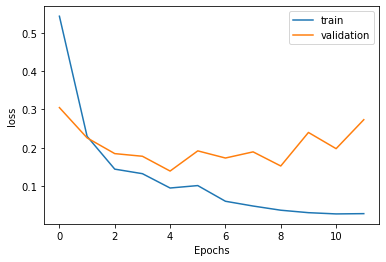

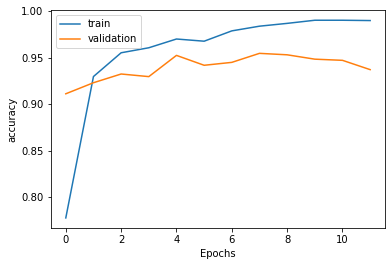

In [20]:
plot_graphs(history, 'loss')
plot_graphs(history, 'accuracy')


### Make predictions

In [21]:
vox_list, output_list_gt = next(data_gen_test)
# gt_mask_list = output_list_gt[0]
pred_proba_class = model.predict(vox_list)


In [22]:
indx = np.random.randint(BATCH_SIZE)
vox_pc= vox_list[indx,:]
gt_label = class_names[np.argmax(output_list_gt[indx,:])]
print(f'Ground truth label: {gt_label}')
pred_label = class_names[np.argmax(pred_proba_class[indx,:])]
print(f'Predicted label: {pred_label}')

Ground truth label: Saddleback roof
Predicted label: Saddleback roof
